In [80]:
#
# File:            z5206979_MTRN4110_PhaseC.ipynb
# Date:            16/07/2021
# Description:     Controller of E-puck for Phase C - Copmuter Vision
# Author:          Noah Correa
# Modifications: 
# Platform:        Windows
# Notes:           
#

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imutils
from scipy import ndimage
from math import floor


In [105]:
# Constants
MAZE_PATH = "../Maze_2.png"
ROBOT_PATH = "../Robot_2.png"
MAP_PATH = "../MapBuilt.txt"
TARGET_PATH = "../Ladybug_small.png"
MAP_SOLUTION = "../MapSolution.txt"

# example = 6

# if example != 1:
#     MAZE_PATH = "../test/Maze_" + str(example) + ".png"
#     ROBOT_PATH = "../test/Robot_" + str(example) + ".png"
#     MAP_PATH = "../test/MapBuilt_" + str(example) + ".txt"
#     MAP_SOLUTION = "../test/MapSolution_" + str(example) + ".txt"

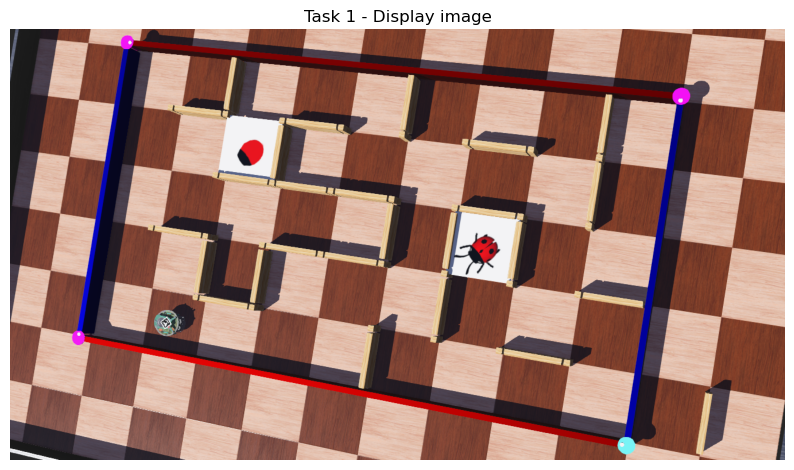

In [106]:
# Task 1
# Read in image and display it in RGB
def task1(plot=False):
    # Read in images
    maze_img = cv2.cvtColor(cv2.imread(MAZE_PATH), cv2.COLOR_BGR2RGB)
    robot_img = cv2.cvtColor(cv2.imread(ROBOT_PATH), cv2.COLOR_BGR2RGB)
    target_img = cv2.cvtColor(cv2.imread(TARGET_PATH), cv2.COLOR_BGR2RGB)
    # marker_img = cv2.cvtColor(cv2.imread(MARKER_PATH), cv2.COLOR_BGR2RGB)

    if plot:
        # Plot image
        plt.figure(figsize = (10, 10))
        plt.plot(), plt.imshow(maze_img), plt.axis('off'), plt.title(f"Task 1 - Display image"), plt.show()

    return maze_img, robot_img, target_img

maze_img, robot_img, target_img = task1(plot=True)

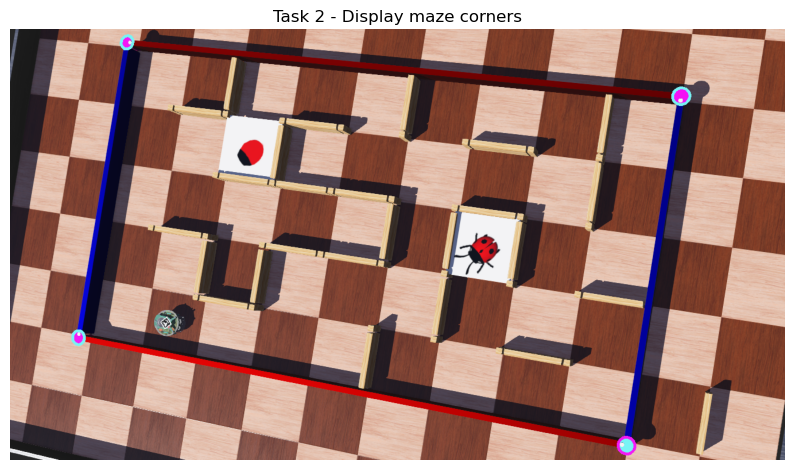

In [107]:
# Task 2
# Find the four ordered cornerstones
def task2(maze_img, plot=False):
    # Convert image to HSV colourspace
    maze_cp = np.copy(maze_img)
    maze_hsv = cv2.cvtColor(maze_cp, cv2.COLOR_RGB2HSV)

    # Set minimum and maximum HSV values for cyan to display
    low_cyan = np.array([80,40,230])
    high_cyan = np.array([100, 255, 255])
    low_pink = np.array([140,200,200])
    high_pink = np.array([170, 255, 255])

    # Convert to HSV format and color threshold
    cyan_mask = cv2.inRange(maze_hsv, low_cyan, high_cyan)
    pink_mask = cv2.inRange(maze_hsv, low_pink, high_pink)

    kernel = np.ones((3,3), np.uint8)
    cyan_mask = cv2.morphologyEx(cyan_mask, cv2.MORPH_OPEN, kernel)
    cyan_mask = cv2.morphologyEx(cyan_mask, cv2.MORPH_CLOSE, kernel)
    pink_mask = cv2.morphologyEx(pink_mask, cv2.MORPH_OPEN, kernel)
    pink_mask = cv2.morphologyEx(pink_mask, cv2.MORPH_CLOSE, kernel)

    _, cyan_contours, _ = cv2.findContours(cyan_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    _, pink_contours, _ = cv2.findContours(pink_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    centers = []
    for c in cyan_contours:
        if len(c) >= 5:
            e = cv2.fitEllipse(c)
            centers.append(e[0])
            cv2.ellipse(maze_cp, e, (243, 25, 245), 3)

    for c in pink_contours:
        if len(c) >= 5:
            e = cv2.fitEllipse(c)
            centers.append(e[0])
            cv2.ellipse(maze_cp, e, (120, 243, 245), 3)

    centers = np.float32(centers)

    # Define cornerstone regions
    regionA = [[0, 0], [375, 337.5]]
    regionB = [[30, 1012.5], [375, 1350]]
    regionC = [[375, 0], [750, 337.5]]
    regionD = [[375, 1012.5], [750, 1350]]

    # # Re-order centers for perspective transform
    ordered_centers = []
    if inRegion(centers[0], regionA):
        ordered_centers = orderPoints(centers, 'A')
    else:
        ordered_centers = orderPoints(centers, 'D')

    
    if plot:
        # Plot maze with circles on cornerstones
        plt.figure(figsize = (10, 10))
        plt.plot(), plt.imshow(maze_cp), plt.axis('off'), plt.title("Task 2 - Display maze corners"), plt.show()

    return maze_cp, ordered_centers

# Checks if given point lies within given region
def inRegion(point, region):
    top, left = region[0]
    bottom, right = region[1]
    x, y = point
    if top <= y <= bottom and left <= x <= right: 
        return True

    return False

# Orders the points for perspective transformation
def orderPoints(points, region):
    rect = np.zeros((4, 2), dtype = "float32")
    s = points.sum(axis = 1)
    rect[0] = points[np.argmin(s)]
    rect[3] = points[np.argmax(s)]
    diff = np.diff(points, axis = 1)
    rect[1] = points[np.argmin(diff)]
    rect[2] = points[np.argmax(diff)]
    if region is 'D':
        rect = np.array((rect[3],rect[2],rect[1],rect[0]))

    return rect

maze_corners, corners = task2(maze_img, plot=True)

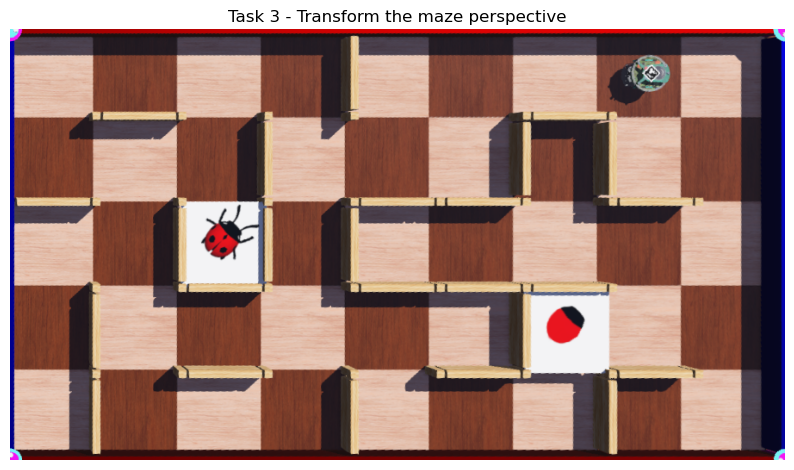

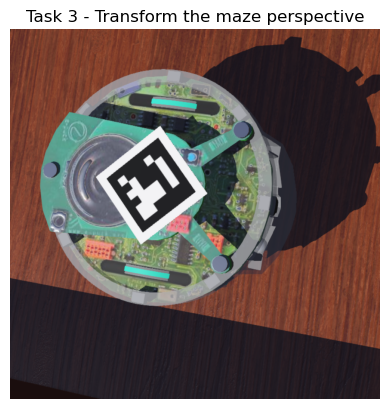

In [117]:
# Task 3
# Perspective transform the maze to a rectangle
def task3(maze_img, corners, robot_img, plot=False):
    end_corners = np.float32([[0, 0], [900, 0], [0, 500], [900, 500]])
    # print(corners)
    # Transform maze perspective
    matrix = cv2.getPerspectiveTransform(corners, end_corners)
    maze_transformed = cv2.warpPerspective(maze_img, matrix, (900, 500))

    # Transform robot perspective
    robot_cp = np.copy(robot_img)
    robot_cp = cv2.resize(robot_cp, (750,750), fy=0.5, interpolation=cv2.INTER_AREA)
    # robot_cp = cv2.resize(robot_cp, (750,750), interpolation=cv2.INTER_AREA)
    robot_transformed = cv2.warpPerspective(robot_cp, matrix, (750,750))


    # HSV threshold robot image to get only the robot
    low_robot = (21,0,0)
    high_robot = (89, 255, 255)
    robot_hsv = cv2.cvtColor(robot_transformed, cv2.COLOR_RGB2HSV)
    robot_mask = cv2.inRange(robot_hsv, low_robot, high_robot)

    # robot_mask = cv2.erode(robot_mask, (5,5))

    # Find the bounding box for the robot
    _, contours, _ = cv2.findContours(robot_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = 0, 0, 0, 0
    for c in contours:
        cx,cy,cw,ch = cv2.boundingRect(c)
        if cw > w and ch > h:
            x, y, w, h = cx, cy, cw, ch
    
    # Crop the robot image to contain only the robot
    robot_crop = robot_transformed[y:y+h,x:x+w]
    # plt.plot(), plt.imshow(robot_img), plt.axis('off'), plt.title("Task 3 - Transform the maze perspective")
    # plt.show()

    # Plot results
    if plot:
        plt.plot(), plt.imshow(maze_transformed), plt.axis('off'), plt.title("Task 3 - Transform the maze perspective")
        plt.show()
        # plt.plot(), plt.imshow(robot_img), plt.axis('off'), plt.title("Task 3 - Transform the maze perspective")
        # plt.show()
        # plt.plot(), plt.imshow(robot_cp), plt.axis('off'), plt.title("Task 3 - Transform the maze perspective")
        # plt.show()
        # plt.plot(), plt.imshow(robot_crop), plt.axis('off'), plt.title("Task 3 - Transform the maze perspective")
        # plt.show()

    return maze_transformed, robot_crop


maze_transformed, robot_transformed = task3(maze_corners, corners, robot_img, plot=True)

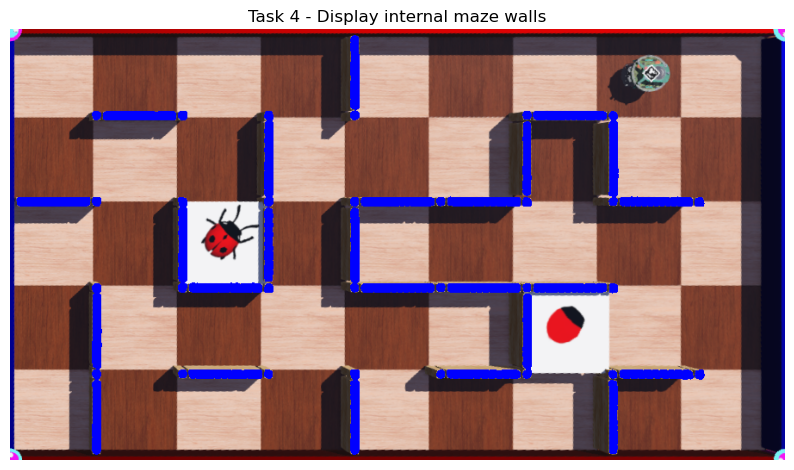

In [114]:
# Task 4
# Detect all the internal walls
def task4(maze_img, plot=False):
    maze_cp = np.copy(maze_img)
    maze_grey = cv2.cvtColor(maze_cp, cv2.COLOR_RGB2GRAY)
    maze_hsv = cv2.cvtColor(maze_cp, cv2.COLOR_RGB2HSV)
    low_walls = (15, 30, 225)
    high_walls = (30, 130, 240)

    # HSV threshold for walls
    wall_mask = cv2.inRange(maze_hsv, low_walls, high_walls)
    wall_mask = cv2.GaussianBlur(wall_mask,(5,5),cv2.BORDER_DEFAULT)
    _, wall_mask = cv2.threshold(wall_mask,50,255,cv2.THRESH_BINARY)

    # Find and draw contours
    contours = cv2.findContours(wall_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(maze_cp, contours[1], -1, (0,0,255), thickness=-1)

    vWalls = [[" " for i in range(8)] for j in range(5)]
    hWalls = [["   " for i in range(4)] for j in range(9)]

    # Vertical walls
    for i in range(5):
        x = (100 * i + 50)
        for j in range(8):
            y = (100 * j + 100)
            roi = wall_mask[x-20:x+20, y-20:y+20]
            if np.count_nonzero(roi) >= 10:
                vWalls[i][j] = "|"

    # Horizontal walls
    for i in range(9):
        y = (100 * i + 50)
        for j in range(4):
            x = (100 * j + 100)
            roi = wall_mask[x-20:x+20, y-20:y+20]
            if np.count_nonzero(roi) >= 10:
                hWalls[i][j] = "---"

    # Plot Results
    if plot:
        plt.figure(figsize = (10, 10))
        plt.plot(), plt.imshow(maze_cp), plt.axis('off'), plt.title("Task 4 - Display internal maze walls"), plt.show()
    return maze_cp, hWalls, vWalls

maze_walls, hWalls, vWalls = task4(maze_transformed, plot=True)

In [115]:
# Task 5
# Detect the location and heading of the robot
def task5(maze_img, robot_img, explicit_coords=False, plot=False):
    # Determine robot location
    maze_cp = np.copy(maze_img)
    maze_hsv = cv2.cvtColor(maze_cp, cv2.COLOR_RGB2HSV)

    # HSV threshold the image to find robot location
    low_robot = (21,0,0)
    high_robot = (89, 255, 255)
    robot_mask = cv2.inRange(maze_hsv, low_robot, high_robot)

    # Find robot contours
    _, robot_contours, _ = cv2.findContours(robot_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find all minimum enclosing circles for all contours
    centers = []
    radii = []
    for c in robot_contours:
        center, radius = cv2.minEnclosingCircle(c)
        centers.append(center)
        radii.append(radius)

    # Find min enclosing circle with largest radius to get robot location
    robot_index = np.argmax(radii)
    robot_center = (int(centers[robot_index][0]), int(centers[robot_index][1]))
    robot_radius = int(radii[robot_index])

    # Draw circle on robot location
    cv2.circle(maze_cp, robot_center, robot_radius, (255, 0, 0), 2)


    # Determine robot orientation
    # Detect ArUco marker
    arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_50)
    arucoParams = cv2.aruco.DetectorParameters_create()
    (corners, ids, rejected) = cv2.aruco.detectMarkers(robot_img, arucoDict, parameters=arucoParams)
    
    # plt.plot(), plt.imshow(robot_img), plt.axis('off'), plt.title("Task 5 - Display robot location and heading")
    # plt.show()
    # print(corners)

    # Find the direction the top-left corner of the marker is facing
    # (Top-left corner of marker represents the forward direction of the robot)
    marker_size_x = np.abs(corners[0][0][0][0] - corners[0][0][2][0])
    marker_size_y = np.abs(corners[0][0][0][1] - corners[0][0][2][1])
    marker_size = max(marker_size_x, marker_size_y)
    x, y = corners[0][0][0]
    height, width = robot_img.shape[0:2]
    if x > width//2 + marker_size//4:
        heading = ">"
        offset_x = -12
        offset_y = 10
    elif x < width//2 - marker_size//4:
        heading = "<"
        offset_x = -11
        offset_y = 10
    elif y < height//2 - marker_size//4:
        heading = "^"
        offset_x = -11
        offset_y = 9
    else:
        heading = "v"
        offset_x = -9
        offset_y = 9
        
    # Display heading in center of robot
    text_origin = (robot_center[0] + offset_x, robot_center[1] + offset_y)
    cv2.putText(maze_cp, heading, text_origin, cv2.FONT_HERSHEY_PLAIN, 2, (255,0,0), 2, cv2.LINE_AA)
    
    # Transform robot location to cell notation
    rx = int(floor(robot_center[0] / 100.0))
    ry = int(floor(robot_center[1] / 100.0))
    robot_loc = [rx,ry,heading]

    if explicit_coords is True:
        robot_loc = [rx*100-50, ry*100-50, heading]

    # Plot the results
    if plot:
        plt.figure(figsize = (10, 10))
        plt.plot(), plt.imshow(maze_cp), plt.axis('off'), plt.title("Task 5 - Display robot location and heading"), plt.show()

    return maze_cp, robot_loc

maze_robot, robot_loc = task5(maze_walls, robot_transformed, plot=True)


IndexError: list index out of range

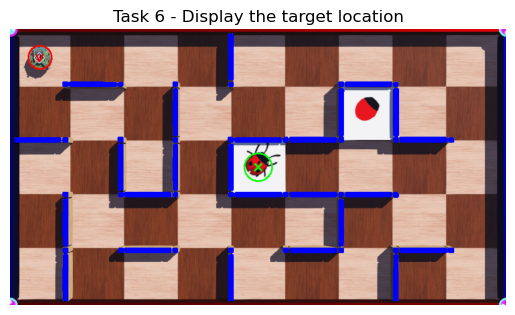

In [103]:
# Task 6
# Detect the position of the true target
def task6(maze_img, target_img, plot=False):
    maze_cp = np.copy(maze_img)
    maze_hsv = cv2.cvtColor(maze_cp, cv2.COLOR_RGB2HSV)

    ladybug_grey = cv2.cvtColor(target_img, cv2.COLOR_RGB2GRAY)
    maze_image_transformed_grey = cv2.cvtColor(maze_cp, cv2.COLOR_RGB2GRAY)

    # Initiate SIFT detector
    params={}
    params["n_features"]=0
    params["n_octave_layers"]=3
    params["contrast_threshold"]=0.03
    params["edge_threshold"]=10
    params["sigma"]=0.8

    sift = cv2.xfeatures2d.SIFT_create(
                    nfeatures=params["n_features"],
                    nOctaveLayers=params["n_octave_layers"],
                    contrastThreshold=params["contrast_threshold"],
                    edgeThreshold=params["edge_threshold"],
                    sigma=params["sigma"])

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(ladybug_grey, None)
    kp2, des2 = sift.detectAndCompute(maze_image_transformed_grey, None)

    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

    # Match descriptors.
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    # Initialize lists

    # For each match...
    for match in matches[:1]:
        img2_idx = match.trainIdx
        (ladybug_centre_x, ladybug_centre_y) = kp2[img2_idx].pt
        
    ladybug_centre_x_index = ladybug_centre_x // 100
    ladybug_centre_y_index = ladybug_centre_y // 100
    ladybug_centre_x_final = int(ladybug_centre_x_index * 100 + 50)
    ladybug_centre_y_final = int(ladybug_centre_y_index * 100 + 50)

    target_center = (ladybug_centre_x_final, ladybug_centre_y_final)
    target_radius = 25

    # Draw target circle and marker
    cv2.circle(maze_cp, target_center, target_radius, (0, 255, 0), 2)
    text_origin = (target_center[0] - 10, target_center[1] + 8)
    cv2.putText(maze_cp, 'x', text_origin, cv2.FONT_HERSHEY_PLAIN, 2, (0,255,0), 2, cv2.LINE_AA)

    # Transform robot location to cell notation
    tx = int(floor(target_center[1] / 100.0))
    ty = int(floor(target_center[0] / 100.0))
    target_loc = [tx,ty]

    # Plot the results
    if plot:
        plt.plot(), plt.imshow(maze_cp), plt.axis('off'), plt.title("Task 6 - Display the target location")
        plt.show()

    return maze_cp, target_loc

maze_target, target_loc = task6(maze_robot, target_img, plot=True)

In [104]:
# Task 7
# Generate a map and write it to a text file
def task7(hWalls, vWalls, robot_loc, target_loc, plot=False):
    # print(robot_loc)
    hWall = "---"
    hEmpty = "   "
    vWall = "|"
    vEmpty = " "
    robot = " " + robot_loc[2] + " "
    target = " x "

    top = [hWall for i in range(9)]
    with open(MAP_PATH, 'w+') as f:
        # Loop through each line
        for i in range(11):
            # Top or bottom lines
            if i == 0 or i == 10:
                row = vEmpty + vEmpty.join(top) + vEmpty
            # Horizontal walls
            elif i % 2 == 0:
                row = vEmpty
                for j in range(9):
                    row = row + hWalls[j][i//2-1] + vEmpty
            
            # Vertical walls
            else:
                # Check if target or robot is in current line 
                if target_loc[0] == i//2 or robot_loc[0] == i//2:
                    row = vWall
                    # Loop through each col and vertical wall
                    for j in range(0, 18):
                        # Check if j is a cell
                        if j%2 == 1:
                            # Check if target is in current cell
                            if target_loc[0] == i//2 and j//2 == target_loc[1]:
                                row = row + " x "
                            # Check if robot is in current cell
                            elif robot_loc[0] == i//2 and j//2 == robot_loc[1]:
                                row = row + " " + robot_loc[2] + " "
                            # Otherwise 
                            else:
                                row = row + hEmpty
    
                        # Check if j is not a cell
                        elif j != 0:
                            row = row + vWalls[i//2][j//2-1]
                    row = row + vWall

                # If robot or target is not on current line, print out whole line
                else:
                    row = vWall + hEmpty + hEmpty.join(vWalls[i//2]) + hEmpty + vWall
            # If not last line, add a newline
            if i != 10:
                row = row + "\n"
            # Write map to file
            f.write(row)
            if plot:
                print(row, end="")
            
    print(f"\nGenerated map to file \"{MAP_PATH}\"")            
    return

task7(hWalls, vWalls, robot_loc, target_loc, plot=True)

 --- --- --- --- --- --- --- --- --- 
| v             |                   |
     ---                 ---         
|           |           |   |       |
 ---             --- ---     ---     
|       |   |   | x                 |
         ---     --- --- ---         
|   |                   |           |
         ---         ---     ---     
|   |           |           |       |
 --- --- --- --- --- --- --- --- --- 
Generated map to file "../MapBuilt.txt"


In [71]:
# Motion Tracking
def trackRobot(video_path, robot_img, transform=True):
    video = cv2.VideoCapture(video_path)
    
    # _, startloc = task
    points = []
    first_frame = None
    while True:
        success, frame = video.read()

        if not success:
            break
        
        # frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # frame_grey = cv2.GaussianBlur(frame_grey, (21, 21), 0)

        if first_frame is None:
            first_frame = frame
            continue
        
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_corners, corners = task2(frame_rgb)
        frame_transformed, _ = task3(frame_corners, corners, robot_img)
        _, location = task5(frame, robot_img, explicit_coords=True)

        points.append((location[0],location[1]))
        # print(f"point={location}")

        # frameDelta = cv2.absdiff(first_frame, frame_grey)
        # thresh = cv2.threshold(frameDelta, 25, 255, cv2.THRESH_BINARY)[1]
        # # dilate the thresholded image to fill in holes, then find contours
        # # on thresholded image
        # thresh = cv2.dilate(thresh, None, iterations=2)
        # cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # cnts = imutils.grab_contours(cnts)
        # # loop over the contours
        # for c in cnts:
        #     # if the contour is too small, ignore it
        #     if cv2.contourArea(c) < 1:
        #         continue
        #     # compute the bounding box for the contour, draw it on the frame,
        #     # and update the text
        #     (x, y, w, h) = cv2.boundingRect(c)
        #     point = (int(x+w/2), int(y+h/2))
        #     points.append(point)
        #     # cv2.line(frame, (x)
        #     # cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        	# show the frame and record if the user presses a key

        result = cv2.cvtColor(frame_transformed, cv2.COLOR_RGB2BGR)
        # print(f"result={result.shape}")
        # result = cv2.resize(result, (900,500), cv2.INTER_AREA)

        if len(points) == 2:
            # print(f"A={points[0]}, B={points[1]}")
            cv2.line(result, points[0], points[1], (0,0,255), 2)
        elif len(points) > 2:
            for i in range(len(points)-1):
                # print(f"A={points[i]}, B={points[i+1]}")
                cv2.line(result, points[i], points[i+1], (0,0,255), 4)


        cv2.imshow("Maze", result)

        # next_frame = frame


        key = cv2.waitKey(1) & 0xFF
        # if the `q` key is pressed, break from the lop
        if key == ord("q"):
            break

    # cleanup the camera and close any open windows
    video.release()
    cv2.destroyAllWindows()



trackRobot("../MTRN4110_PhaseD.mp4", robot_img, transform=True)

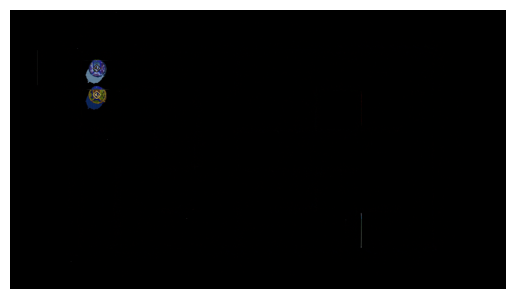

In [36]:
fps = 30

second = 5
second = np.clip(second, 0, len(frames)-1)
frameD = cv2.absdiff(frames[0], frames[1])
plt.plot(), plt.imshow(frameD), plt.axis('off'), plt.title("")
plt.show()

In [ ]:
# TESTING
# Compare outputs of maps

# result = filecmp.cmp(MAP_SOLUTION, MAP_PATH, shallow=False)
# if result is True:
#     print("Maps differ.")
# else:
#     print("Maps match!")


# with open(MAP_SOLUTION) as file_1, open(MAP_PATH) as file_2:
#     differ = Differ()
  
#     for line in differ.compare(file_1.readlines(), file_2.readlines()):
#         print(line)

In [ ]:

# def nothing(x):
#     pass
# # Creating a window for later use
# cv2.namedWindow('image')

# # Starting with 100's to prevent error while masking
# hMin = sMin = vMin = hMax = sMax = vMax = 0
# phMin = psMin = pvMin = phMax = psMax = pvMax = 0

# # Creating track bar
# cv2.createTrackbar('HMin', 'image', 0, 179, nothing)
# cv2.createTrackbar('SMin', 'image', 0, 255, nothing)
# cv2.createTrackbar('VMin', 'image', 0, 255, nothing)
# cv2.createTrackbar('HMax', 'image', 0, 179, nothing)
# cv2.createTrackbar('SMax', 'image', 0, 255, nothing)
# cv2.createTrackbar('VMax', 'image', 0, 255, nothing)

# cv2.setTrackbarPos('HMax', 'image', 179)
# cv2.setTrackbarPos('SMax', 'image', 255)
# cv2.setTrackbarPos('VMax', 'image', 255)

# while(1):

#     frame = cv2.cvtColor(np.copy(robot_img), cv2.COLOR_RGB2BGR)
#     # Convert to HSV format and color threshold
#     hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

#     # get info from track bar and appy to result
#     hMin = cv2.getTrackbarPos('HMin', 'image')
#     sMin = cv2.getTrackbarPos('SMin', 'image')
#     vMin = cv2.getTrackbarPos('VMin', 'image')
#     hMax = cv2.getTrackbarPos('HMax', 'image')
#     sMax = cv2.getTrackbarPos('SMax', 'image')
#     vMax = cv2.getTrackbarPos('VMax', 'image')

#     # Set minimum and maximum HSV values to display
#     lower = np.array([hMin, sMin, vMin])
#     upper = np.array([hMax, sMax, vMax])


#     mask = cv2.inRange(hsv, lower, upper)
#     result = cv2.bitwise_and(frame, frame, mask=mask)

#     cv2.imshow('image', result)

#     k = cv2.waitKey(1) & 0xFF
#     if k == 27:
#         break

# cv2.destroyAllWindows()